In [2]:
import torch
from torch import Tensor, nn
from math import ceil


```math
gelu(x) = x * \Phi(x) = 0.5*x*(1+\tanh(\sqrt{2/\pi}*(x+0.044715*x^3)))
```

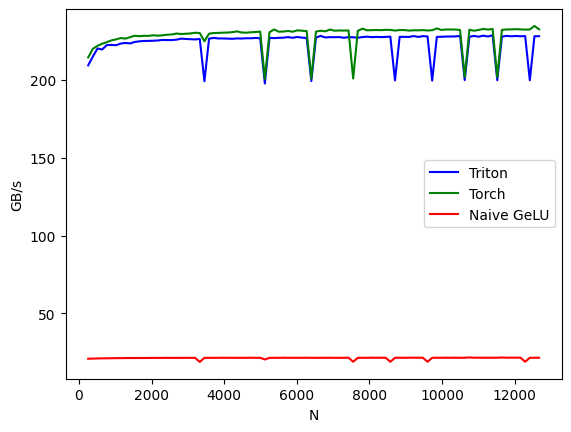

softmax-performance:
          N      Triton       Torch  Naive GeLU
0     256.0  209.483773  214.560654   20.869780
1     384.0  215.143102  220.144687   21.009381
2     512.0  220.298216  222.021202   21.087992
3     640.0  219.690003  223.396919   21.160203
4     768.0  222.500012  224.374322   21.189931
5     896.0  222.613044  225.543211   21.222886
6    1024.0  222.435587  226.169785   21.302826
7    1152.0  223.475744  227.041093   21.288595
8    1280.0  223.907290  226.655294   21.349037
9    1408.0  223.561183  227.594923   21.363669
10   1536.0  224.498421  228.492180   21.374096
11   1664.0  224.928663  228.213174   21.386401
12   1792.0  225.159484  228.480844   21.379106
13   1920.0  225.207004  228.417789   21.392515
14   2048.0  225.299638  228.816757   21.424708
15   2176.0  225.481058  228.567168   21.437992
16   2304.0  225.799300  228.798926   21.427905
17   2432.0  225.702885  229.190308   21.473031
18   2560.0  225.745491  229.320169   21.445534
19   2688.0  225.97

In [ ]:
import triton
import triton.language as tl
DEVICE = torch.device('cuda')

import math


@triton.jit
def gelu_kernel(x_pointer, out_pointer, num_elements, block_size: tl.constexpr):

    pid = tl.program_id(axis=0)
    pointer_offset = pid*block_size + tl.arange(0, block_size)

    mask = pointer_offset < num_elements

    x = tl.load(x_pointer + pointer_offset, mask)

    const = tl.sqrt(2 / math.pi)
    angle = const * (x + 0.044715 * x * x * x)
    tanh = (tl.exp(2 * angle) - 1) / (tl.exp(2 * angle) + 1)
    chunk_res = 0.5 * x * (1 + tanh)

    tl.store(out_pointer + pointer_offset, chunk_res, mask)


def gelu_triton(x:Tensor, block_size: int = 2048) -> Tensor:

    num_elements = x.numel()
    grid = ceil(num_elements/block_size),

    out = torch.empty_like(x).to(x.device)

    gelu_kernel[grid](x, out, num_elements, block_size)

    return out


### performance
x = torch.rand(100).to(DEVICE)

def naive_gelu(x:Tensor) -> Tensor:
    const = math.sqrt(2 / math.pi)
    angle = const * (x + 0.044715 * x * x * x)
    tanh = torch.nn.functional.tanh(angle)
    return 0.5 * x * (1 + tanh)

triton.testing.assert_close(gelu_triton(x), naive_gelu(x))

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch', 'naive_galu'],  # possible values for `line_arg``
        line_names=["Triton", "Torch", "Naive GeLU"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.nn.functional.silu(x))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: silu_triton(x))
    if provider == 'naive_galu':
        ms = triton.testing.do_bench(lambda: naive_gelu(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)


In [3]:
layer = nn.GELU

AttributeError: module 'torch.nn' has no attribute 'Gelu'